In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd

df_train = pd.read_csv('/content/drive/MyDrive/LSTM DATASET /train_motion_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/LSTM DATASET /test_motion_data.csv')

Mounted at /content/drive


In [3]:
# Global constants
TIMESTEPS = 20 # the number of sample to be fed to the NN
FEATURES = 6
LABELS = 3
N_RECORDS = 11
# CNN constantS
N_COLUMNS = 4
N_LENGTH = TIMESTEPS // N_COLUMNS
N_ROWS = 1 # 1 for 1D data

In [4]:
# Split the samples by class
# so it can be trimmed to a desired shape
df_train_normal = df_train.loc[df_train['Class'] == 'NORMAL']
df_train_slow = df_train.loc[df_train['Class'] == 'SLOW']
df_train_aggressive = df_train.loc[df_train['Class'] == 'AGGRESSIVE']

df_test_normal = df_test.loc[df_test['Class'] == 'NORMAL']
df_test_slow = df_test.loc[df_test['Class'] == 'SLOW']
df_test_aggressive = df_test.loc[df_test['Class'] == 'AGGRESSIVE']

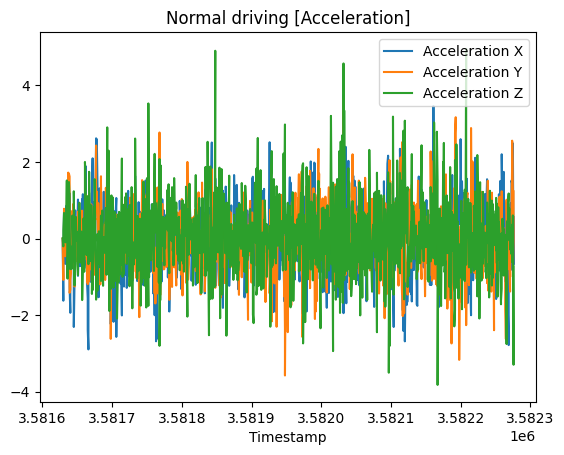

In [5]:
# Normal driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(df_train_normal['Timestamp'], df_train_normal['AccX'], label='Acceleration X')
plt.plot(df_train_normal['Timestamp'], df_train_normal['AccY'], label='Acceleration Y')
plt.plot(df_train_normal['Timestamp'], df_train_normal['AccZ'], label='Acceleration Z')

plt.title('Normal driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

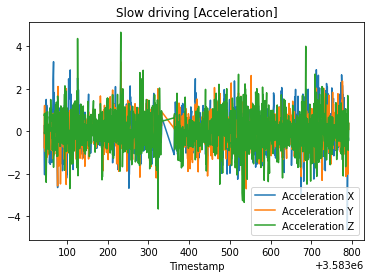

In [ ]:
# Slow driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(df_train_slow['Timestamp'], df_train_slow['AccX'], label='Acceleration X')
plt.plot(df_train_slow['Timestamp'], df_train_slow['AccY'], label='Acceleration Y')
plt.plot(df_train_slow['Timestamp'], df_train_slow['AccZ'], label='Acceleration Z')

plt.title('Slow driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

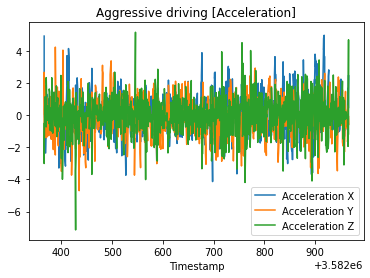

In [ ]:
# Aggresive driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(df_train_aggressive['Timestamp'], df_train_aggressive['AccX'], label='Acceleration X')
plt.plot(df_train_aggressive['Timestamp'], df_train_aggressive['AccY'], label='Acceleration Y')
plt.plot(df_train_aggressive['Timestamp'], df_train_aggressive['AccZ'], label='Acceleration Z')

plt.title('Aggressive driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

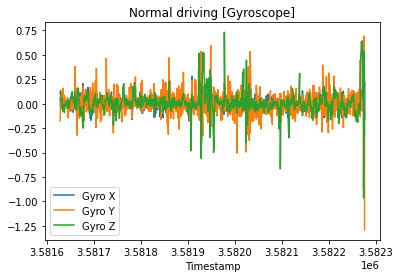

In [ ]:
# Normal driving behavior's gyroscope orientation
import matplotlib.pyplot as plt

plt.plot(df_train_normal['Timestamp'], df_train_normal['GyroX'], label='Gyro X')
plt.plot(df_train_normal['Timestamp'], df_train_normal['GyroY'], label='Gyro Y')
plt.plot(df_train_normal['Timestamp'], df_train_normal['GyroZ'], label='Gyro Z')

plt.title('Normal driving [Gyroscope]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

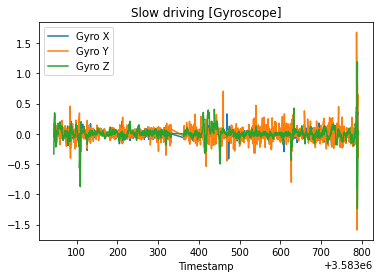

In [ ]:
# Slow driving behavior's gyroscope orientation
import matplotlib.pyplot as plt

plt.plot(df_train_slow['Timestamp'], df_train_slow['GyroX'], label='Gyro X')
plt.plot(df_train_slow['Timestamp'], df_train_slow['GyroY'], label='Gyro Y')
plt.plot(df_train_slow['Timestamp'], df_train_slow['GyroZ'], label='Gyro Z')

plt.title('Slow driving [Gyroscope]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

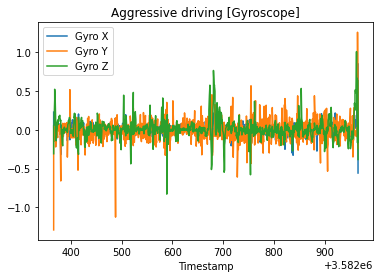

In [ ]:
# Agressive driving behavior's gyroscope orientation
import matplotlib.pyplot as plt

plt.plot(df_train_aggressive['Timestamp'], df_train_aggressive['GyroX'], label='Gyro X')
plt.plot(df_train_aggressive['Timestamp'], df_train_aggressive['GyroY'], label='Gyro Y')
plt.plot(df_train_aggressive['Timestamp'], df_train_aggressive['GyroZ'], label='Gyro Z')

plt.title('Aggressive driving [Gyroscope]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

In [6]:
# As it may be noticed, there is some noice
# at the beggin and end of every time series
# It is caused because of the class switching
# ---------------------------------------------
# A solution would be to just remove the first and last N samples
df_train_slow = df_train_slow.iloc[N_RECORDS:]
df_train_slow = df_train_slow.iloc[:-N_RECORDS]

df_test_slow = df_test_slow.iloc[N_RECORDS:]
df_test_slow = df_test_slow.iloc[:-N_RECORDS]

df_train_normal = df_train_normal.iloc[N_RECORDS:]
df_train_normal = df_train_normal.iloc[:-N_RECORDS]

df_test_normal = df_test_normal.iloc[N_RECORDS:]
df_test_normal = df_test_normal.iloc[:-N_RECORDS]

df_train_aggressive = df_train_aggressive.iloc[N_RECORDS:]
df_train_aggressive = df_train_aggressive.iloc[:-N_RECORDS]

df_test_aggressive = df_test_aggressive.iloc[N_RECORDS:]
df_test_aggressive = df_test_aggressive.iloc[:-N_RECORDS]

In [7]:
# Check train data per label
train_slow_samples = df_train_slow.__len__()
train_normal_samples = df_train_normal.__len__()
train_aggressive_samples = df_train_aggressive.__len__()

print('---Train---')
print('Slow samples: ' + str(train_slow_samples))
print('Normal samples: ' + str(train_normal_samples))
print('Aggressive samples: ' + str(train_aggressive_samples))

df_train_slow = df_train_slow.tail(1300)
df_train_normal = df_train_normal.tail(1160)
df_train_aggressive = df_train_aggressive.tail(1080)

---Train---
Slow samples: 1309
Normal samples: 1178
Aggressive samples: 1091


In [8]:
# Check test data per label
test_slow_samples = df_test_slow.__len__()
test_normal_samples = df_test_normal.__len__()
test_aggressive_samples = df_test_aggressive.__len__()

print('---Test---')
print('Slow samples: ' + str(test_slow_samples))
print('Normal samples: ' + str(test_normal_samples))
print('Aggressive samples: ' + str(test_aggressive_samples))

df_test_slow = df_test_slow.tail(1240)
df_test_normal = df_test_normal.tail(960)
df_test_aggressive = df_test_aggressive.tail(780)

---Test---
Slow samples: 1251
Normal samples: 975
Aggressive samples: 792


In [9]:
# Separating features from labels

# Features
X_train_normal = df_train_normal.iloc[: , :FEATURES]
X_train_slow = df_train_slow.iloc[: , :FEATURES]
X_train_aggressive = df_train_aggressive.iloc[: , :FEATURES]

X_test_normal = df_test_normal.iloc[: , :FEATURES]
X_test_slow = df_test_slow.iloc[: , :FEATURES]
X_test_aggressive = df_test_aggressive.iloc[: , :FEATURES]

# Labels
y_train_normal = df_train_normal.Class
y_train_slow = df_train_slow.Class
y_train_aggressive = df_train_aggressive.Class

y_test_normal = df_test_normal.Class
y_test_slow = df_test_slow.Class
y_test_aggressive = df_test_aggressive.Class

In [10]:
# Combine all the samples intro a train dataset
X_train = pd.concat([X_train_slow, X_train_normal, X_train_aggressive])
y_train = pd.concat([y_train_slow, y_train_normal, y_train_aggressive])

X_test = pd.concat([X_test_slow, X_test_normal, X_test_aggressive])
y_test = pd.concat([y_test_slow, y_test_normal, y_test_aggressive])

In [11]:
# As ML/DL algorithms are working with numbers
# the labels should be mapped to numbers
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

In [12]:
# Because I'm using CategoricalCrossentropy loss function
# I have to convert my labels to one-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=LABELS)
y_test = to_categorical(y_test, num_classes=LABELS)

In [13]:
# As the dataset contains variables that are different in scale,
# a good solution will be to standardize it
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Reshaping the input for the Conv-LSTM network (Features)
train_samples = X_train.shape[0]//TIMESTEPS
X_train = X_train.reshape(train_samples, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

test_samples = X_test.shape[0]//TIMESTEPS
X_test = X_test.reshape(test_samples, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

print('Train features shape: ' + str(X_train.shape[0]))
print('Test features shape: ' + str(X_test.shape[0]))

Train features shape: 177
Test features shape: 149


In [15]:
y_train = y_train[::TIMESTEPS]
y_test = y_test[::TIMESTEPS]

print('Train labels shape: ' + str(y_train.shape[0]))
print('Test labels shape: ' + str(y_test.shape[0]))

Train labels shape: 177
Test labels shape: 149


In [16]:
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.layers import Dense, Dropout, Flatten, ConvLSTM2D, LSTM, RepeatVector
import keras_tuner as kt

# Set a global random seed for a better random result
tf.random.set_seed(42)

# Build the model by assigning
# the number of layers and number of neurons for each layer
# the learning rate
# the number of epochs
# ------------------------------------------------------------------------
# To get these optimal parameters I will use the Keras Tuner library
# so it will get the optimal parameters for the NN
# and pass it to the model_builder function
def model_builder(hp):
    model = tf.keras.Sequential()

    model.add(
        ConvLSTM2D(
            filters=hp.Int('filter_units', min_value=16, max_value=64, step=16),
            kernel_size=(1,3),
            activation='relu',
            input_shape=(N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)
            )
        )

    model.add(Dropout(hp.Float('dropout_0_rate', min_value=0, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(Dense(LABELS, activation='softmax'))


    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [17]:
# To be able to get the optimal parameters for our network
# we have to create a Tuner with the following setup
# 'objective' -> will use to create test models
# 'max_epochs' -> the maximum number of epochs to train one model
# 'factor' -> the reduction factor for the number of epochs and number of models for each bracket
# 'directory' -> will save the training history there
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='conv_lstm_dir',
                     project_name='driving_behavior')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Define an event that will stop the training
# depending of the value of "val_loss"
# ------------------------------------------------------------------
# Will stop training if the "val_loss" hasn't improved in 5 epochs.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
# The algorithm trains a large number of models for a few epochs and
# carries forward only the top-performing half of models to the next round.
tuner.search(
        x=X_train,
        y=y_train,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[stop_early],
        shuffle=True
)

Trial 90 Complete [00h 00m 17s]
val_accuracy: 0.42953020334243774

Best val_accuracy So Far: 0.6174496412277222
Total elapsed time: 00h 22m 33s


In [20]:
# Get best hyperparameters that were found during the search
best_model = tuner.get_best_models()[0]

In [21]:
# Get the metrics for our trained model
eval_result = best_model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.6303 - loss: 1.3402 - precision: 0.6295 - recall: 0.5674


In [22]:
# Get the predictions
y_pred=best_model.predict(x=X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


In [23]:
# Transform the predicted scores array to a pretty Dataframe ^^
df_predicted = pd.DataFrame(y_pred, columns=['AGGRESSIVE', 'NORMAL', 'SLOW'])
df_predicted

,AGGRESSIVE,NORMAL,SLOW
0,0.362871,1.779520e-01,4.591773e-01
1,0.261230,1.135965e-01,6.251737e-01
2,0.053498,4.557076e-01,4.907946e-01
3,0.004654,2.437978e-02,9.709666e-01
4,0.082939,5.076320e-01,4.094286e-01
...,...,...,...
144,0.855915,9.426541e-03,1.346582e-01
145,1.000000,3.000932e-11,1.875635e-10
146,0.999722,6.422343e-05,2.136763e-04
147,0.049344,7.739972e-02,8.732563e-01


In [25]:
import numpy as np
# Reverse the one hot encoded vector
actual_y_test = np.argmax(y_test, axis=1)
array_actual = labelEncoder.inverse_transform(actual_y_test)

# Transform the given class array to a Dataframe
df_actual = pd.DataFrame(array_actual, columns = ['Original Class'])
df_actual

,Original Class
0,SLOW
1,SLOW
2,SLOW
3,SLOW
4,SLOW
...,...
144,AGGRESSIVE
145,AGGRESSIVE
146,AGGRESSIVE
147,AGGRESSIVE


In [ ]:
# Combine the actual and resulted classes
df_result = pd.concat([df_predicted, df_actual], axis=1)
df_result

,AGGRESSIVE,NORMAL,SLOW,Original Class
0,0.067655,2.382777e-01,6.940671e-01,SLOW
1,0.046501,9.863400e-02,8.548654e-01,SLOW
2,0.053364,4.041389e-01,5.424969e-01,SLOW
3,0.015636,4.318659e-01,5.524978e-01,SLOW
4,0.010266,7.460076e-01,2.437264e-01,SLOW
...,...,...,...,...
144,0.440835,3.372770e-02,5.254372e-01,AGGRESSIVE
145,1.000000,8.133322e-09,7.134010e-09,AGGRESSIVE
146,0.945292,1.046726e-02,4.424083e-02,AGGRESSIVE
147,0.088048,3.975578e-02,8.721958e-01,AGGRESSIVE


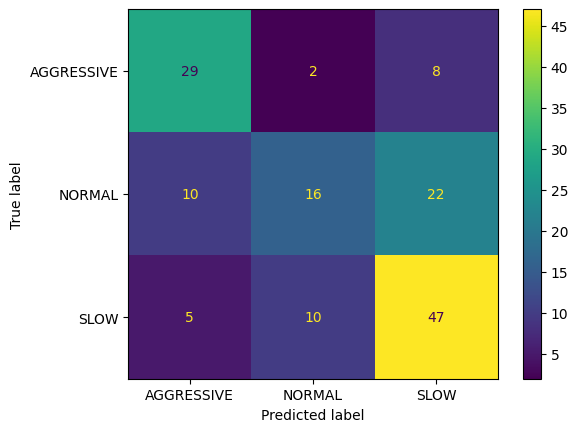

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(actual_y_test, y_pred)

classes = ['AGGRESSIVE', 'NORMAL', 'SLOW']
disp = ConfusionMatrixDisplay.from_predictions(actual_y_test, y_pred, display_labels=classes)

plt.rcParams['figure.figsize'] = [20, 10]
plt.show()


In [27]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 1, 3, 48)            │          31,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 3, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 288)                 │          41,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,923 (288.76 KB)

 Trainable params: 73,923 (288.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
df_result.to_csv('conv_lstm_20.csv')